# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [3]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [0]:
# lazily fill NaNs with zeros
movie_num = df_numeric.fillna(value=0, axis=1).drop(columns='id')

In [9]:
movie_num.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,237000000,150.437577,2787965087,162.0,7.2,11800
1,300000000,139.082615,961000000,169.0,6.9,4500
2,245000000,107.376788,880674609,148.0,6.3,4466
3,250000000,112.312950,1084939099,165.0,7.6,9106
4,260000000,43.926995,284139100,132.0,6.1,2124


# You take it from here!

See what you can come up with. You have all the know-how! 

In [0]:
movie_standardized = 

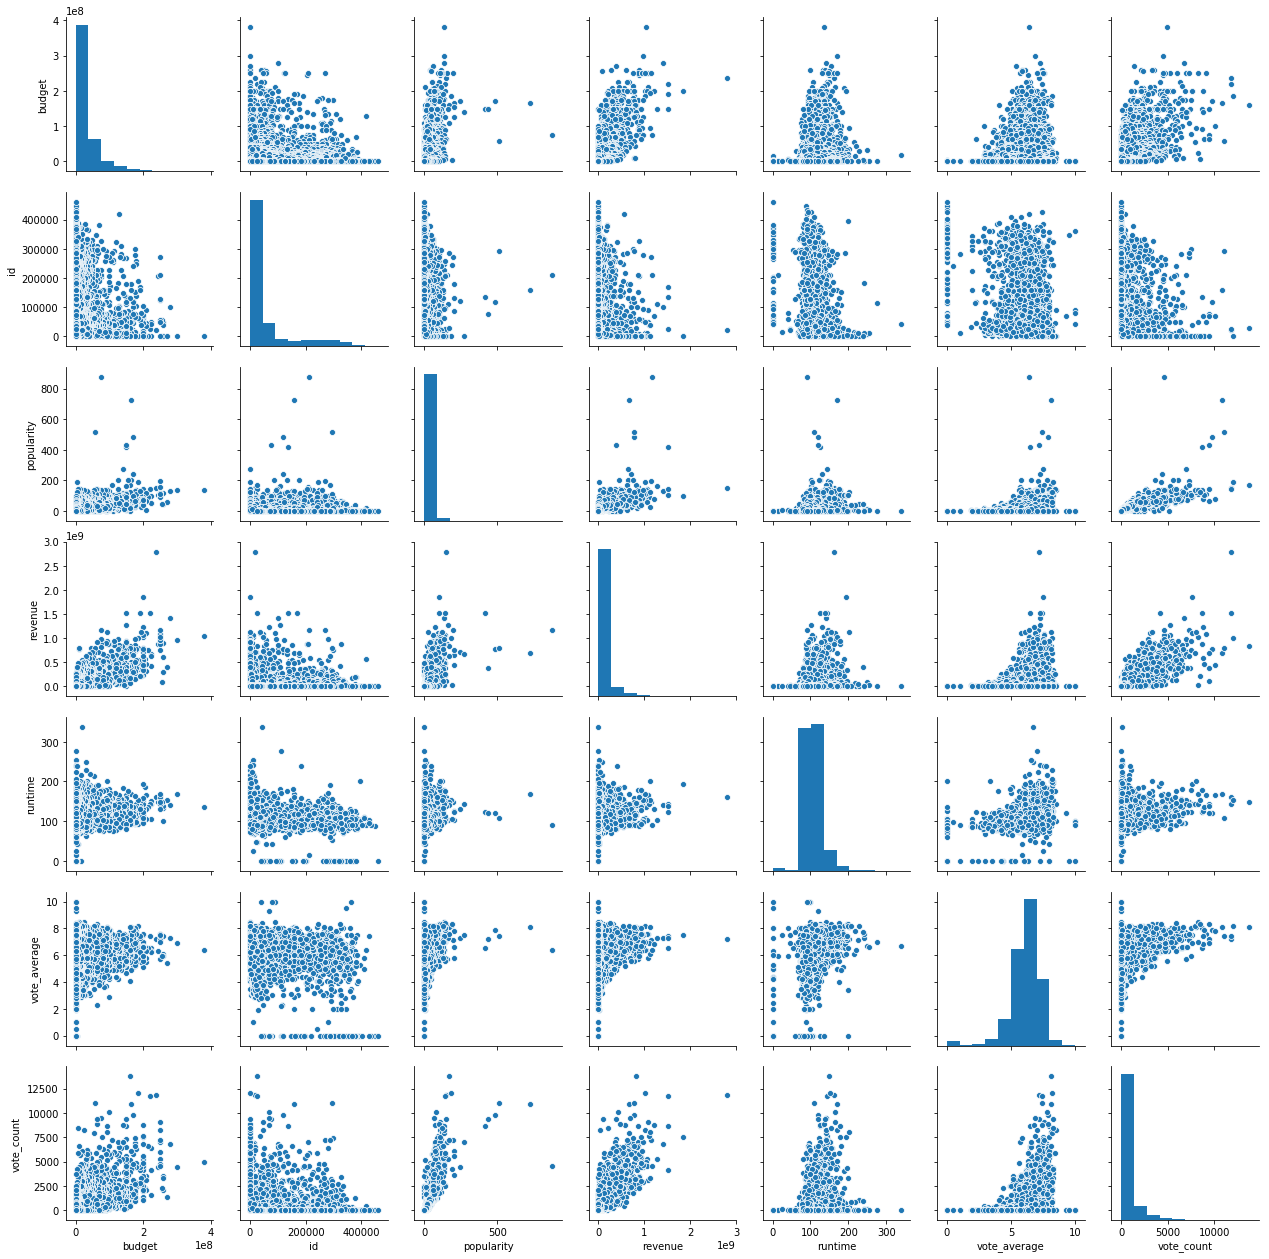

In [7]:
# !pip install seaborn --upgrade
import seaborn as sns
sns.pairplot(movie_num)

In [11]:
## Exploring the Importance of Feature Scaling in PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)


df_explore = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(df_explore,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal components
print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

Automatically created module for IPython interactive environment


ValueError: ignored

In [0]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.